# T1: single-session preprocessing and analysis

This notebook walks through a **single fibre-photometry session** end-to-end using `fibphot`.

You will:
- load a Doric recording,
- inspect raw channels and sampling properties,
- remove transient electrical spikes (Hampel / median),
- low-pass filter to improve signal-to-noise,
- fit and store a **double-exponential photobleaching baseline**,
- perform **isosbestic regression** (OLS or robust IRLS) for motion/artifact correction,
- compute **dF**, **dF/F**, percent change, and (optionally) z-score / null-Z normalisations,
- run basic peak finding for event-style analyses.

## References
- Simpson *et al.* (2023), *Lights, fibre, action! A primer on in vivo fibre photometry* (Neuron). DOI: `10.1016/j.neuron.2023.11.016`
- Keevers & Jean-Richard-dit-Bressel (2025), *Obtaining artifact-corrected signals in fibre photometry via isosbestic signals, robust regression, and dF/F calculations* (Neurophotonics). DOI: `10.1117/1.NPh.12.2.025003`

---

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes

from fibphot.analysis.photobleaching import (
    get_baseline_trace,
    photobleaching_summary,
)
from fibphot.io import read_doric
from fibphot.peaks import PeakFinder
from fibphot.stages import (
    DoubleExpBaseline,
    HampelFilter,
    IsosbesticRegression,
    LowPassFilter,
    Normalise,
    Trim,
)

%config InlineBackend.figure_format = "retina"

## 1) load a `.doric` session

Doric `.doric` files are HDF5 containers. `fibphot.io.read_doric(...)` reads the
timebase and whichever demodulated channels you select into a `PhotometryState`.

**Time units:** Doric stores time as seconds. You can confirm this by checking 
the dataset names (e.g. `.../Time`) and by inspecting the sampling rate computed 
from `np.diff(time_seconds)`.

In [2]:
path: str = "" # TODO: set path to a Doric .doric file

state = read_doric(path)

state.channel_names, state.n_samples, state.sampling_rate

(('gcamp', 'iso'), 23183, 60.24096385543316)

### Quick visual sanity check

Plot the primary signal (e.g. `gcamp`) and control (e.g. `iso`) together.

- The control channel should broadly co-vary with motion/optical artefacts.
- The signal channel should contain both artefacts **and** physiology.


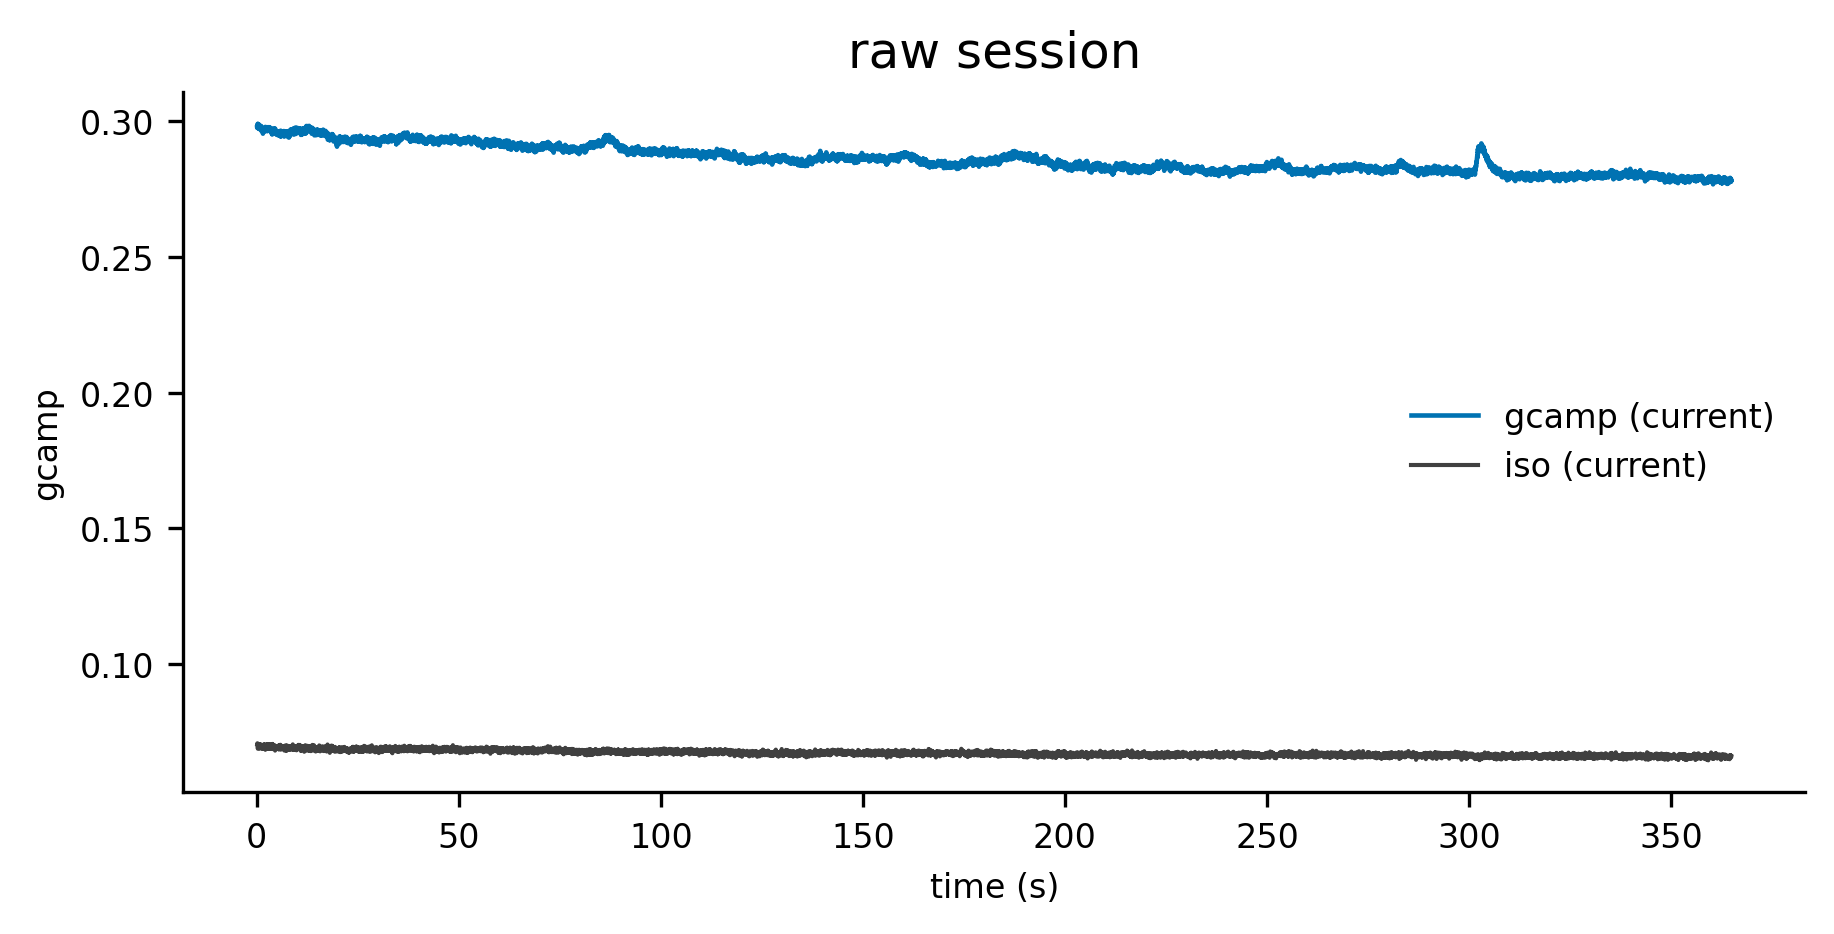

In [3]:
state = Trim(end=20.0, unit="seconds")(state)

fig, ax = state.plot(signal="gcamp", control="iso", title="raw session")
plt.show()

## 2) what artefacts are we targeting?

A photometry trace often contains:

1. **Spike artefacts**: brief, high-amplitude electrical spikes (phones, loose connectors).
2. **High-frequency noise**: detector/amplifier noise; physiological signal is usually slower.
3. **Photobleaching drift**: gradual decay in fluorescence over the session.
4. **Motion/optical coupling**: movement changes coupling efficiency, bending losses, etc.
   Isosbestic/control channels help estimate this component.
5. (Sometimes) **slow baseline wander** from temperature or hardware drift.

There is no single “correct” pipeline for all experiments. The point of this
tutorial is to show a **transparent, reproducible** workflow where each stage:

- records its parameters in `state.summary`,
- stores useful intermediate outputs in `state.derived`,
- stores per-stage outputs/metrics in `state.results`.


## 3) despiking: Hampel vs median filters

### Hampel filter (outlier replacement)
For each time-point $i$, take a local window and compute:
- median, $m_i$
- MAD, $\text{MAD}_i = \text{median}(|x - m_i|)$

Scale MAD to behave like a standard deviation under Normal noise:
$$
\hat\sigma_i \approx 1.4826\,\text{MAD}_i
$$
Then flag outliers where:
$$
|x_i - m_i| > k\,\hat\sigma_i
$$
and replace $x_i$ with the local median.

**Median filter** differs: it replaces *every* point with the local median, so
it smooths the whole trace; Hampel only changes *flagged* points.

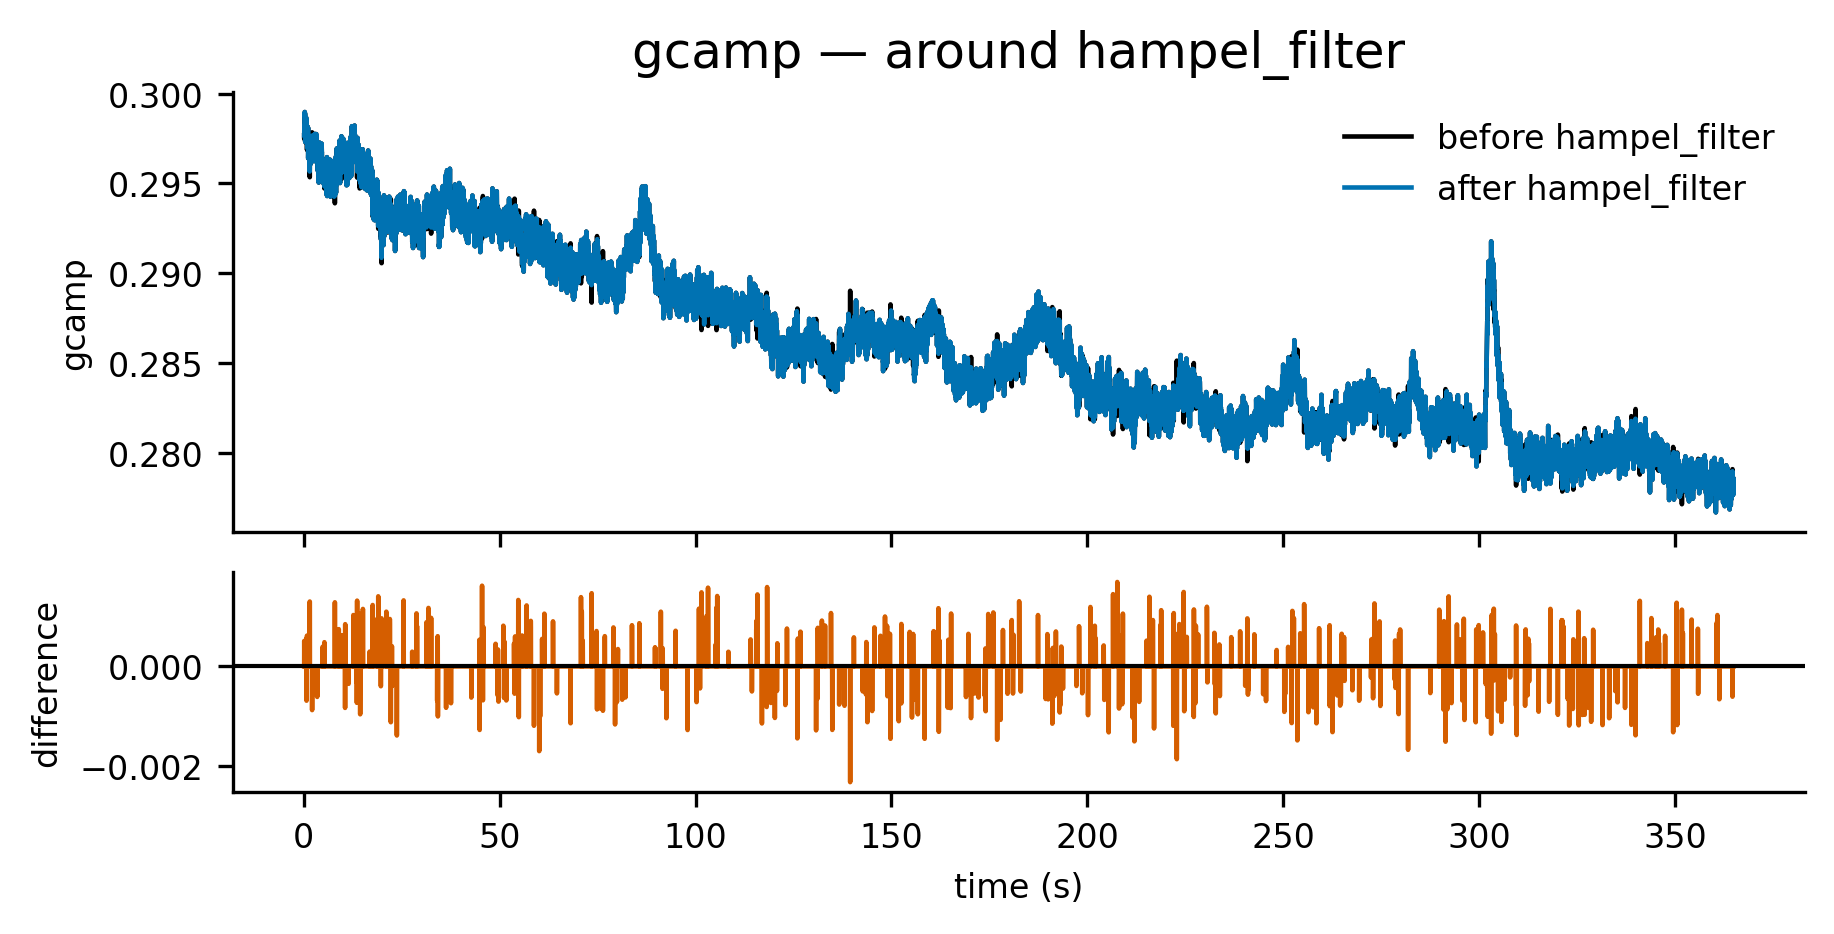

StageRecord(stage_id='0002_hampel_filter', name='hampel_filter', params={'window_size': 13, 'n_sigmas': 3.0, 'channels': 'all', 'mad_scale': 1.4826, 'mode': 'reflect', 'match_edges': True}, metrics={}, notes=None)

In [4]:
# apply Hampel despiking (choose window in samples).
state = HampelFilter(window_size=13, n_sigmas=3.0)(state)

# plot before vs after the despike stage.
fig, ax = state.plot_history(
    channel="gcamp",
    around=True,
    stage_name="hampel_filter",
    plot_difference=True,
)
plt.show()

state.summary[-1]

## 4) low-pass filtering (zero-phase)

We typically low-pass because biosensor kinetics are slow relative to sampling.

With a Butterworth IIR filter, we use `filtfilt` (forward-backward filtering)
to obtain **zero phase shift** (no time-delay), at the cost of using data on
both sides of each point.

Implementation detail: SciPy recommends **SOS** (second-order sections) for
numerical stability, especially at higher orders.


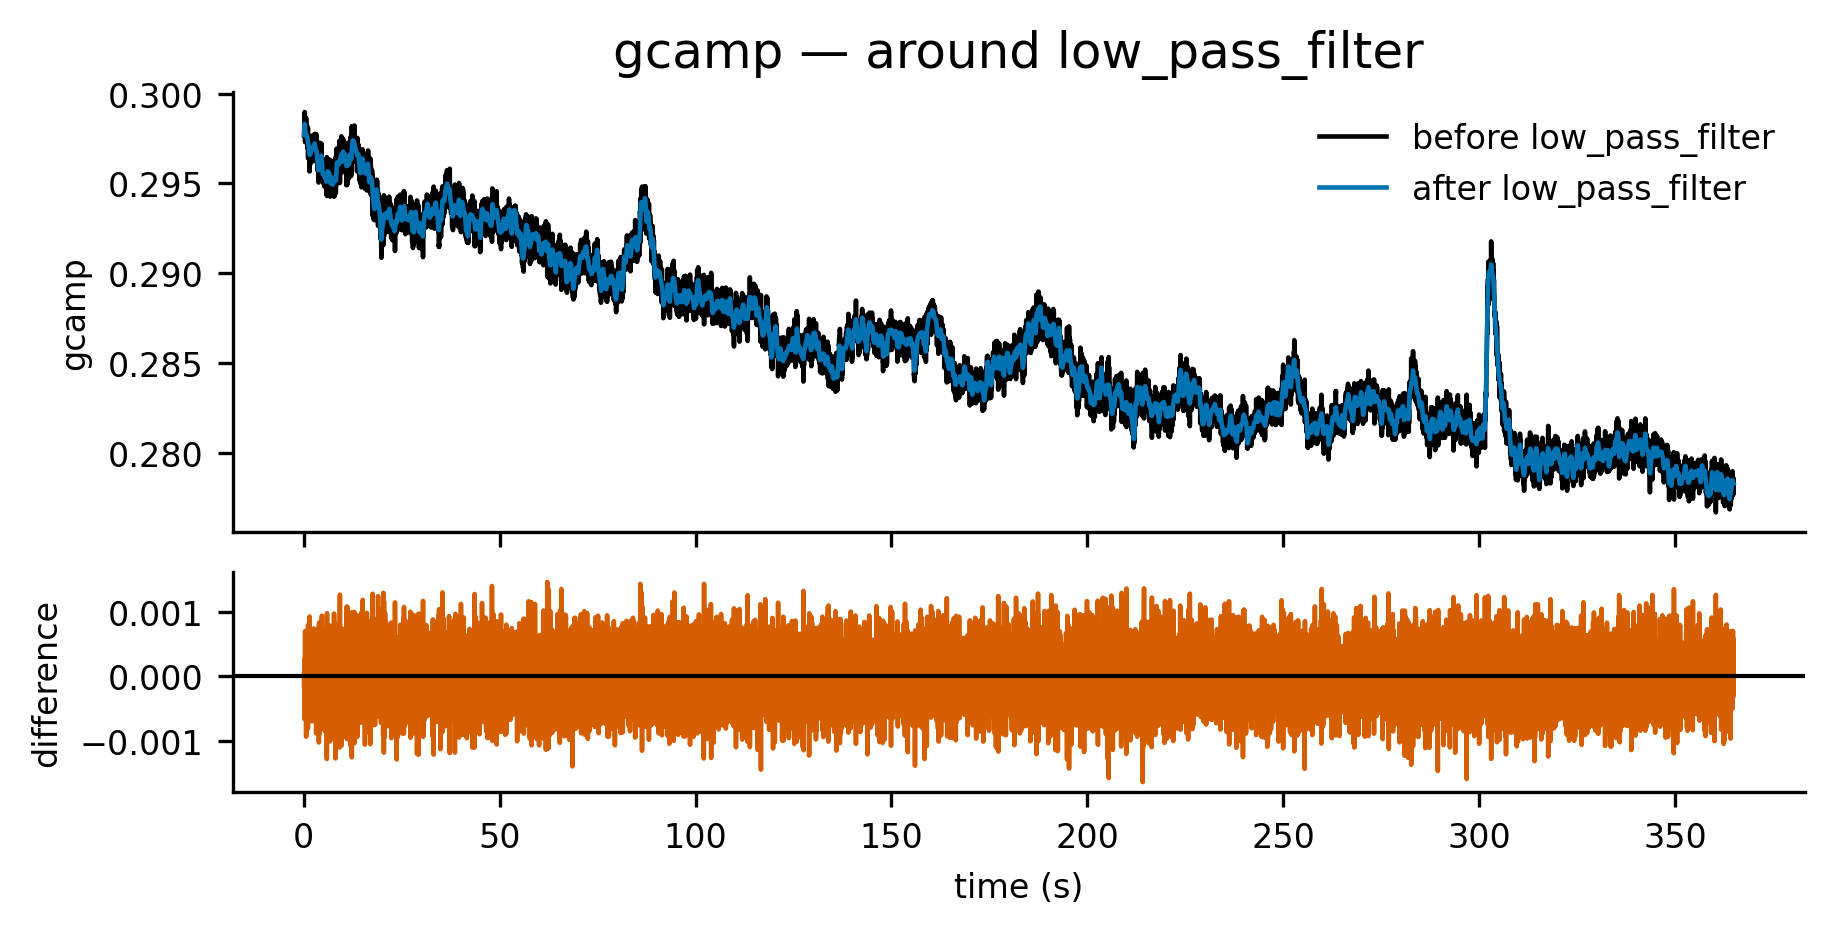

StageRecord(stage_id='0003_low_pass_filter', name='low_pass_filter', params={'critical_frequency': 2.0, 'order': 2, 'sampling_rate': None, 'channels': 'all', 'representation': 'sos'}, metrics={}, notes=None)

In [5]:
state = LowPassFilter(
    critical_frequency=2.0,
    order=2, 
    representation="sos"
)(state)

fig, ax = state.plot_history(
    channel="gcamp",
    around=True,
    stage_name="low_pass_filter",
    plot_difference=True,
)
plt.show()

state.summary[-1]

## 5) photobleaching baseline: double exponential

A common model for photobleaching is:
$$
F_0(t) = c + a_s\exp(-t/\tau_s) + a_f\exp(-t/\tau_f)
$$
where $\tau_s$ and $\tau_f$ are slow/fast decay time constants.

In `fibphot`, `DoubleExpBaseline`:
- fits $F_0(t)$ for selected channels,
- stores the fitted baseline traces in `state.derived["double_exp_baseline"]`,
- optionally subtracts them (`subtract=True`) to produce **detrended** signals.

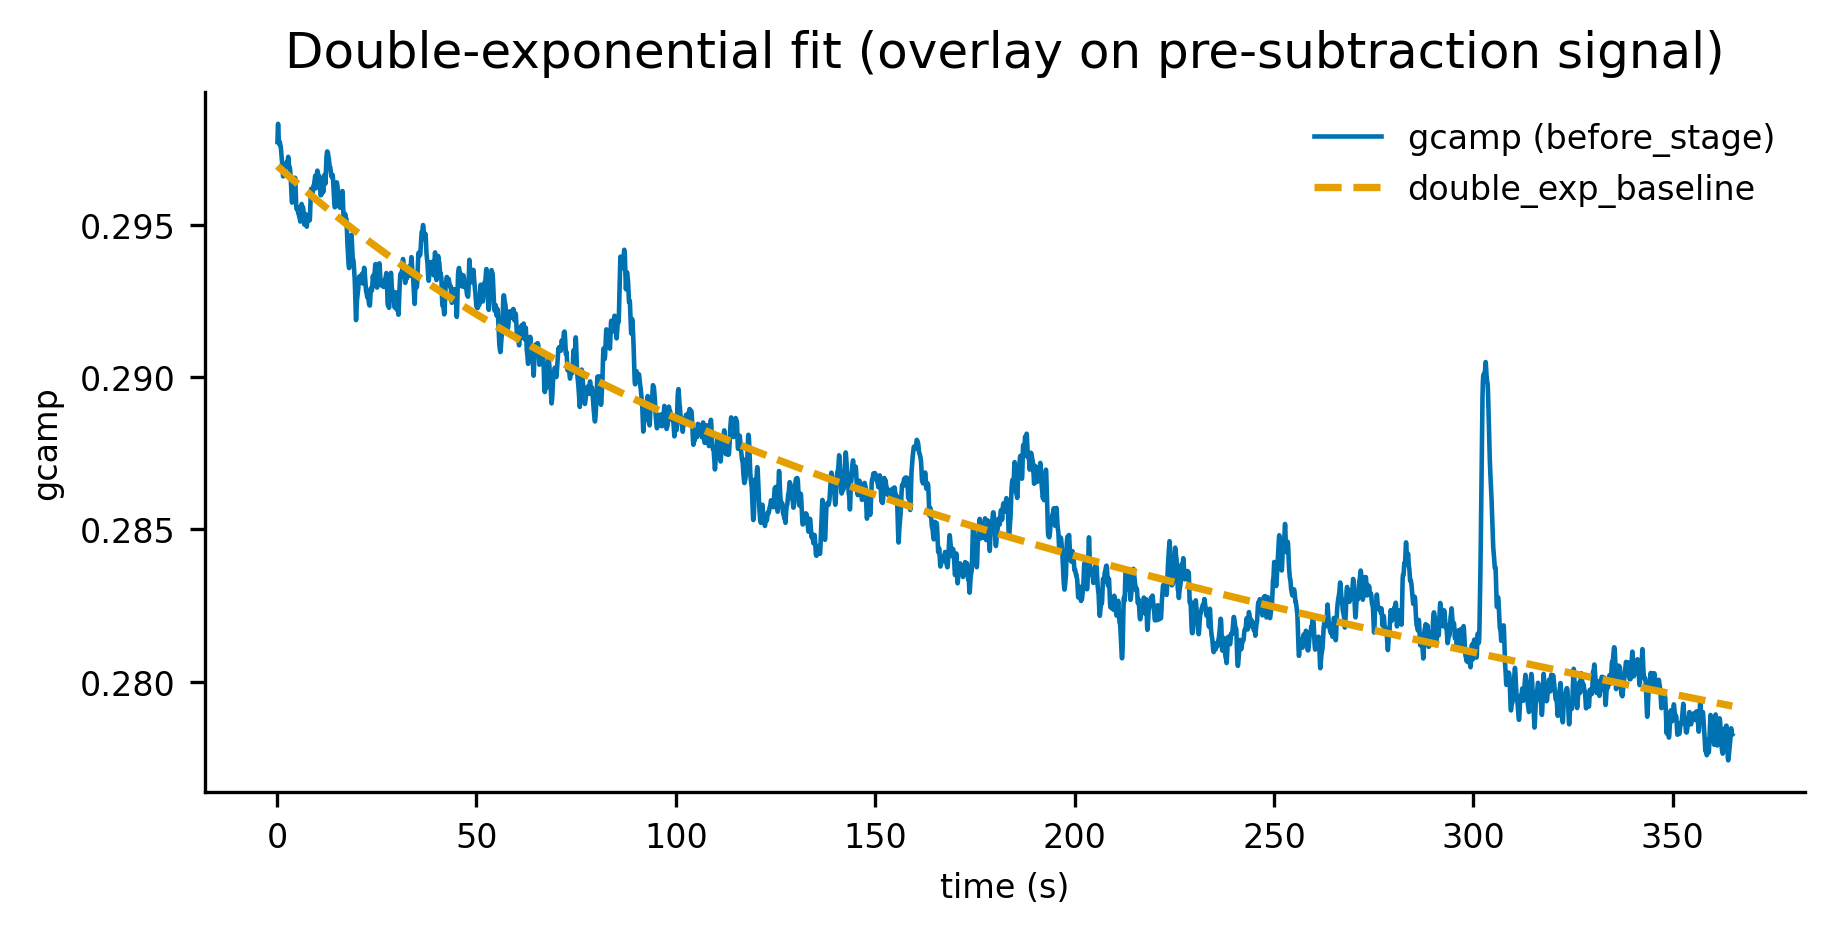

StageRecord(stage_id='0004_double_exp_baseline', name='double_exp_baseline', params={'subtract': True, 'channels': 'all', 'decimate_to_hz': None, 'maxfev': 2000, 'tau_fast_bounds': (60.0, 600.0), 'tau_slow_bounds': (600.0, 36000.0)}, metrics={'mean_r2': 0.9344294129266186, 'mean_rmse': 0.0007678413679641132, 'decimate_factor': 1.0}, notes="Fitted double exponential baseline; parameters are stored per channel. Baseline curves are available in derived['double_exp_baseline'].")

In [6]:
# fit baseline and subtract it from signals (detrend)
state = state.revert_to(stage_name="low_pass_filter")
state = DoubleExpBaseline(subtract=True, decimate_to_hz=None)(state)

# to see the baseline fit, plot the snapshot from before subtraction:
fig, ax = state.plot(
    signal="gcamp",
    baseline_key="double_exp_baseline",
    view="before_stage",
    stage_name="double_exp_baseline",
    title="Double-exponential fit (overlay on pre-subtraction signal)",
)
plt.show()

state.summary[-1]

### Compare photobleaching between channels

A quick diagnostic is to compare:
- time constants $\tau_f, \tau_s$,
- fraction of the decay attributed to fast vs slow components,
- overall percent drop across the session.

This is useful because signal and control channels can bleach differently.


In [7]:
df_bleach = photobleaching_summary(state)
df_bleach

,channel,tau_fast_s,tau_slow_s,fast_amp_frac,slow_amp_frac,has_fast_component,half_drop_time_s,percent_drop,r2,rmse,const,amp_fast,amp_slow,f0_start,f0_end
0,gcamp,96.853222,11583.663507,0.030353,0.969647,False,110.609323,5.968610,0.931090,0.001297,5.089477e-09,0.009013,0.287919,0.296921,0.279199
1,iso,91.809275,15029.441267,0.027326,0.972674,False,103.122823,5.011167,0.937769,0.000239,4.401650e-12,0.001898,0.067574,0.069470,0.065989


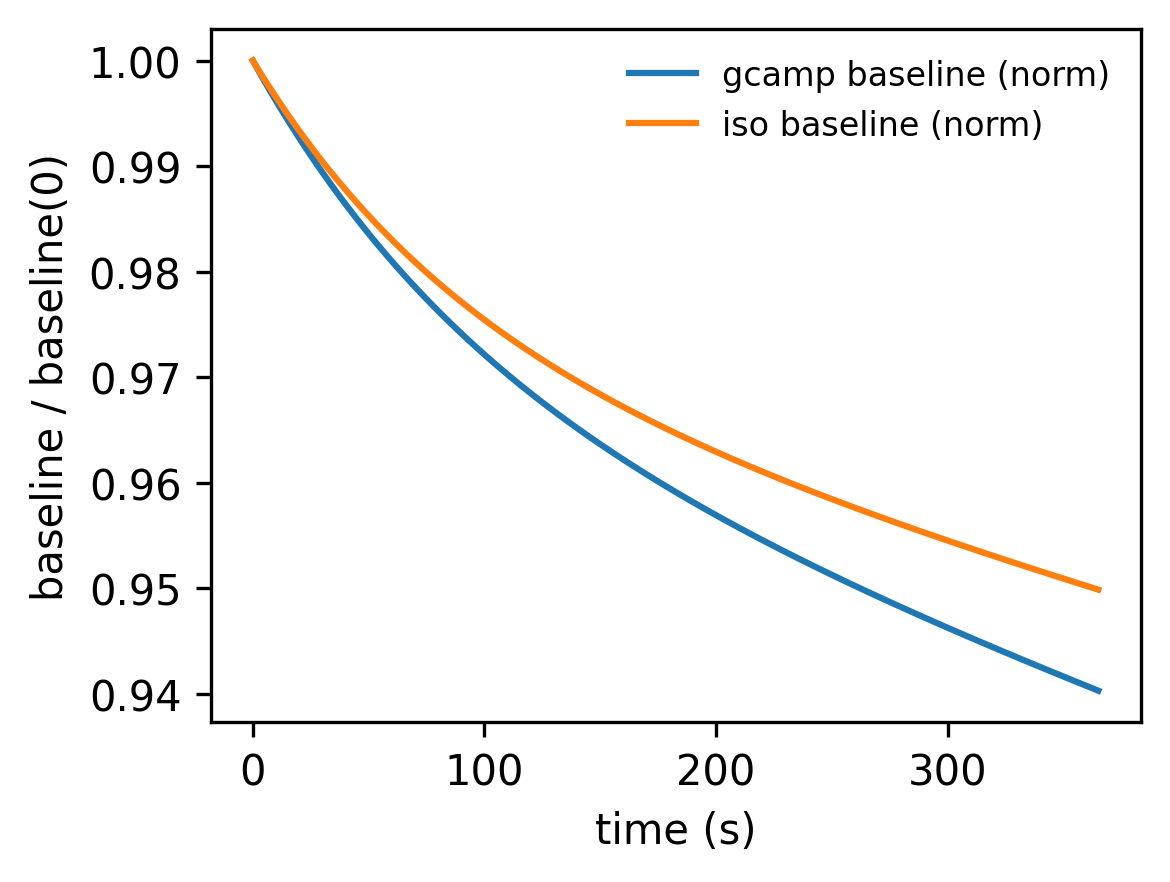

In [8]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

ax.plot(
    state.time_seconds,
    get_baseline_trace(state, channel="gcamp", normalise_to_start=True),
    label="gcamp baseline (norm)"
)
ax.plot(
    state.time_seconds,
    get_baseline_trace(state, channel="iso", normalise_to_start=True),
    label="iso baseline (norm)"
)

ax.set_xlabel("time (s)")
ax.set_ylabel("baseline / baseline(0)")
ax.legend(frameon=False, fontsize=8)
plt.show()

## 6) motion/artifact correction via isosbestic regression (OLS vs IRLS)

After detrending, we regress the control channel $x(t)$ onto the signal $y(t)$:
$$
y(t) \approx \alpha + \beta x(t)
$$
The estimated motion/artifact contribution is:
$$
\hat y(t) = \alpha + \beta x(t)
$$
and the corrected signal (dF) is the residual:
$$
\Delta F(t) = y(t) - \hat y(t)
$$

### Why robust regression?
OLS minimises squared residuals and is sensitive to large transients (true neural
events), which can pull the fit. IRLS (iteratively reweighted least squares)
implements an M-estimator that downweights (Huber) or rejects (Tukey) outliers.

Keevers & Jean‑Richard‑dit‑Bressel (2025) argue robust regression is often a better
default for isosbestic correction.


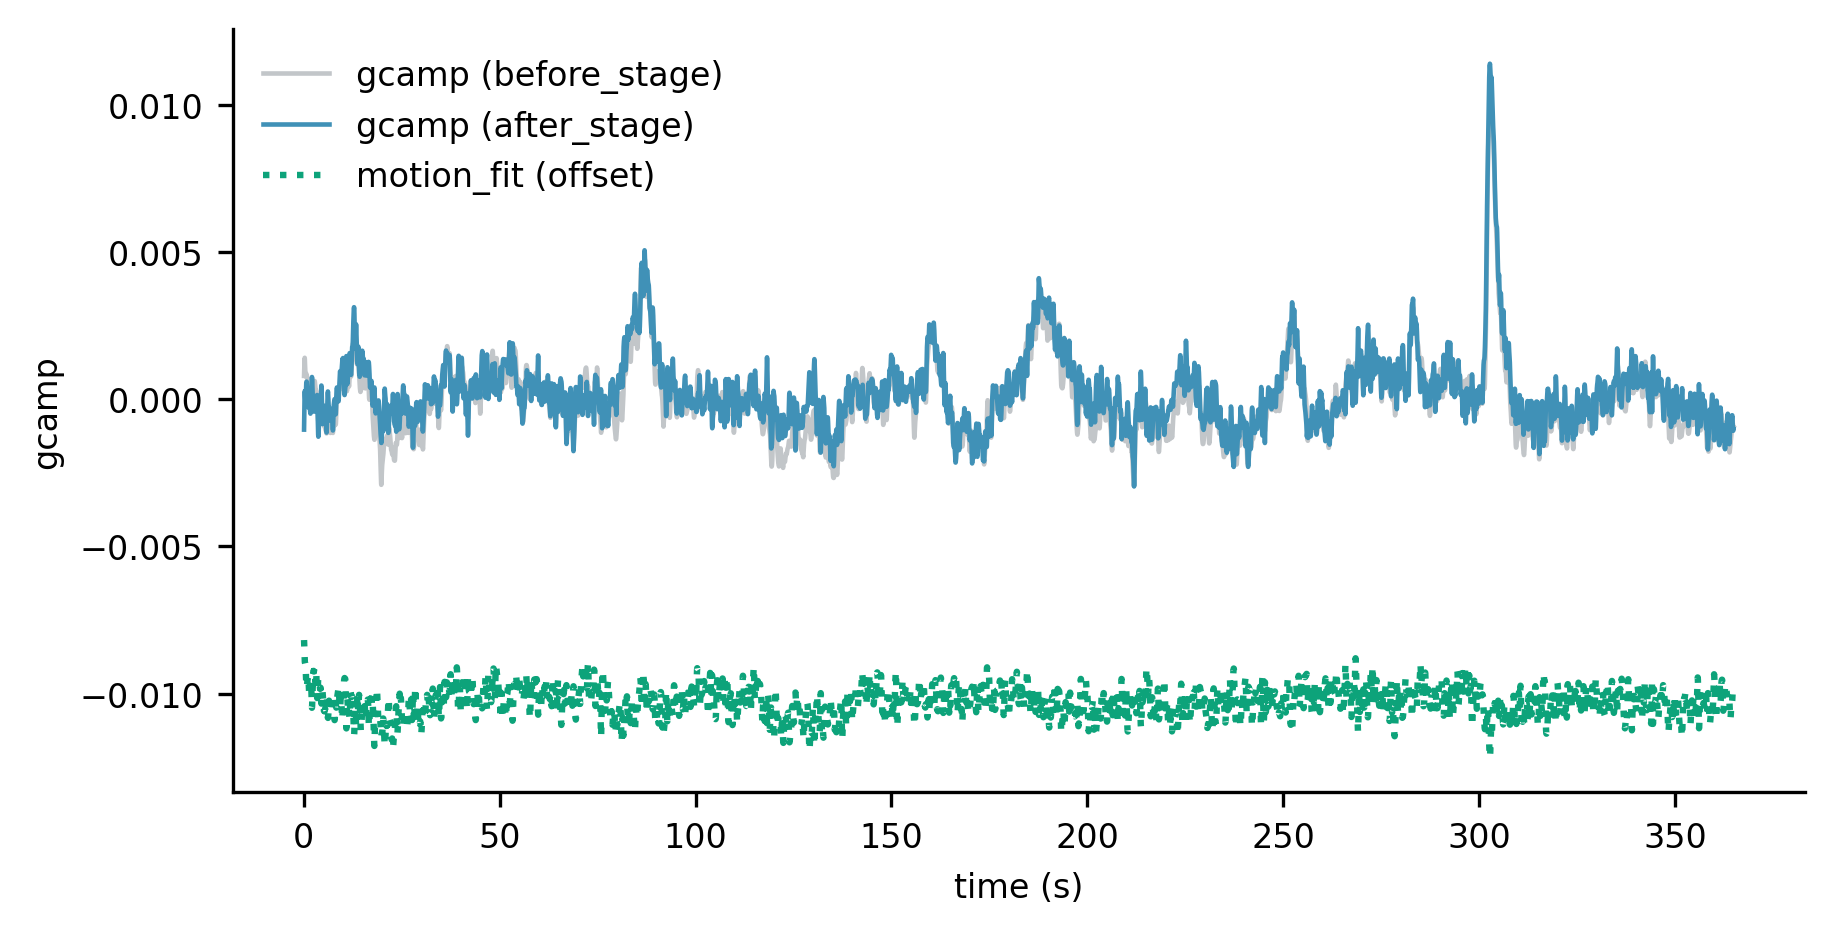

StageRecord(stage_id='0005_isosbestic_regression', name='isosbestic_regression', params={'control': 'iso', 'channels': ['gcamp'], 'method': 'irls_tukey', 'include_intercept': True, 'tuning_constant': 1.4, 'max_iter': 100, 'tol': 1e-10, 'store_weights': False}, metrics={'mean_r2': -0.04112902715672728, 'median_r2': -0.04112902715672728}, notes=None)

In [9]:
state = IsosbesticRegression(
    control="iso",
    channels=["gcamp"],
    method="irls_tukey",
    tuning_constant=1.4,
    store_weights=False,
)(state)

# Plot raw (before regression) vs corrected (after regression)
fig, ax = state.plot(
    signal="gcamp",
    view="before_stage",
    stage_name="isosbestic_regression",
    colour="#9aa0a6",
    alpha=0.6,
)

# add the fitted motion baseline
state.plot(
    signal="gcamp",
    view="after_stage",
    stage_name="isosbestic_regression",
    colour="#4091B7",
    alpha=1.0,
    motion_fit_key="motion_fit",
    overlay_offset={"motion_fit": -0.01},
    ax=ax,
)

plt.show()

state.summary[-1]

### Inspect regression results and weights

The stage stores per-channel fit parameters in `state.results[...]` and the fitted
motion baselines in `state.derived["motion_fit"]`.


In [10]:
# find the last stage_id for isosbestic regression
stage_id = next(
    rec.stage_id
    for rec in reversed(state.summary)
    if rec.name.lower() == "isosbestic_regression"
)

fit = state.results[stage_id]["channels"]["gcamp"]
fit


{'control': 'iso',
 'intercept': -0.00026857652785010913,
 'slope': 2.0109378164444216,
 'r2': -0.04112902715672728,
 'method': 'irls_tukey',
 'n_iter': 63,
 'max_iter': 100,
 'tuning_constant': 1.4,
 'scale': 0.0008534829542471925,
 'weights': None}

## 7) normalisation

At this point, the corrected trace in the `gcamp` channel is effectively 
$\Delta F(t)$.

### Baseline-based dF/F
One normalisation option is to compute:
$$
\%\Delta F/F = 100\,\frac{\Delta F(t)}{F_0(t)}
$$
where $F_0(t)$ is the photobleaching baseline (double exponential fit).


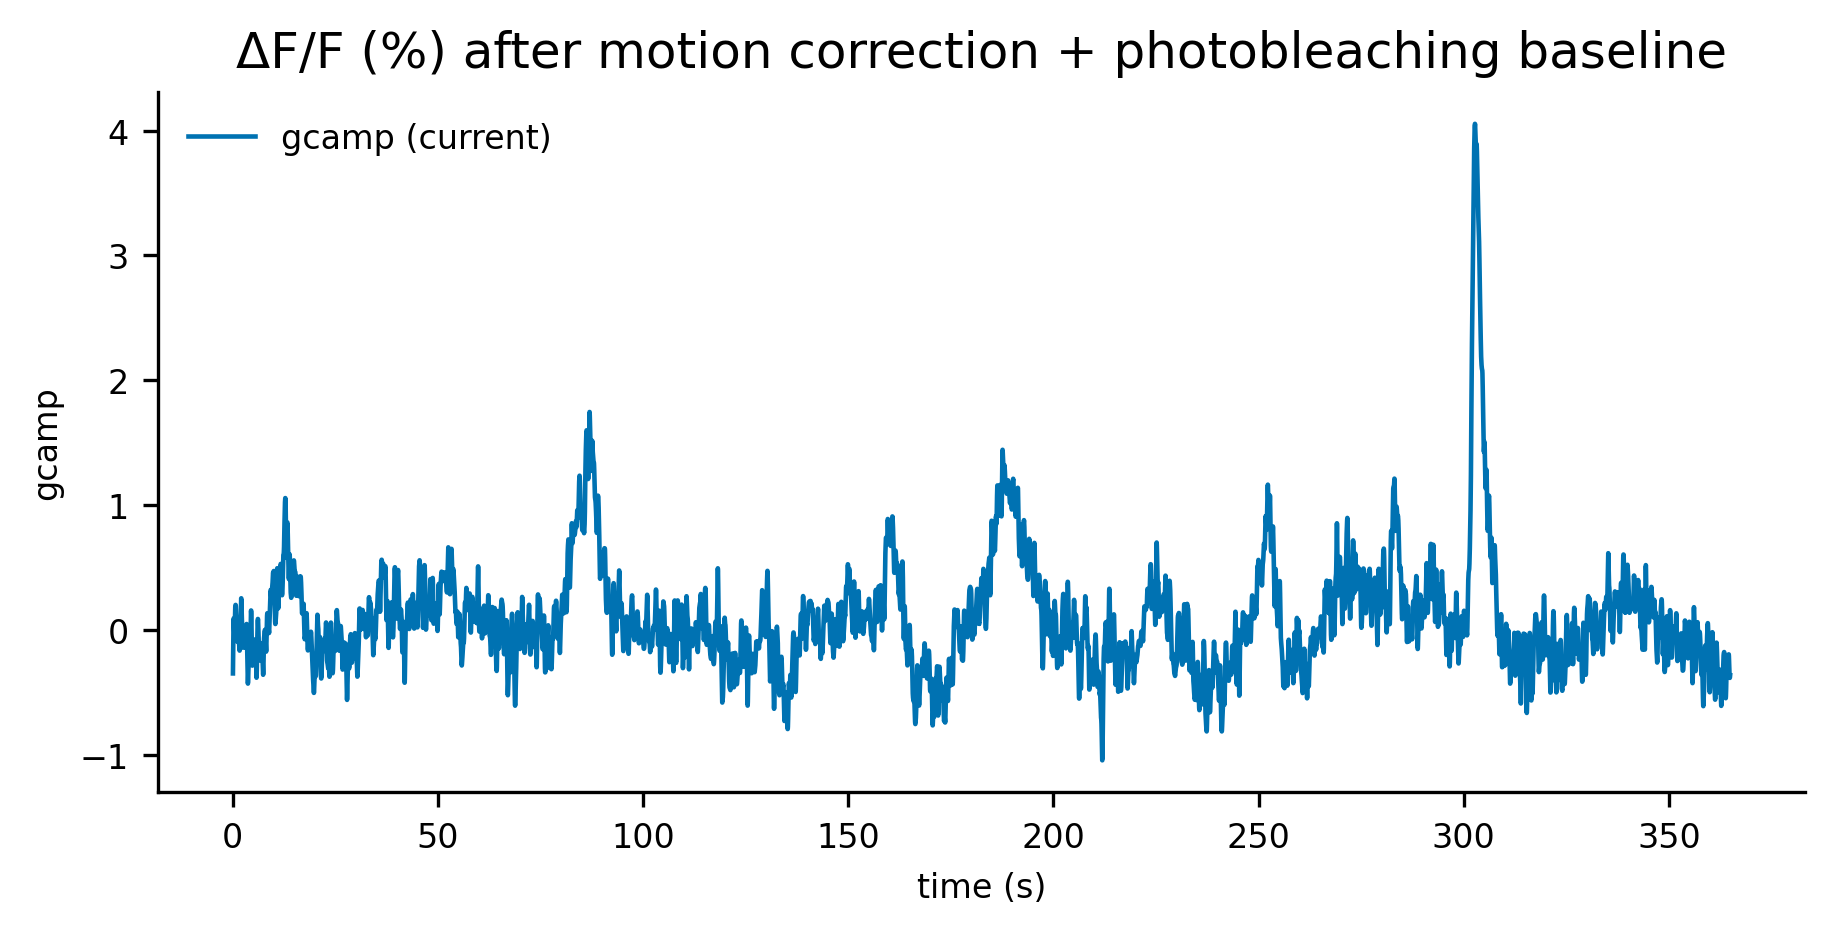

StageRecord(stage_id='0006_normalise', name='normalise', params={'method': 'baseline', 'channels': ['gcamp'], 'baseline_key': 'double_exp_baseline', 'baseline_mode': 'percent', 'time_window': None, 'ddof': 0, 'null_z_scale': 'rms', 'mad_scale': 1.4826, 'eps': 1e-12}, metrics={}, notes=None)

In [11]:
# Convert dF -> dF/F (%) using the stored photobleaching baseline
state_dff = Normalise.baseline(
    channels=["gcamp"],
    baseline_key="double_exp_baseline",
    mode="percent",
)(state)

fig, ax = state_dff.plot(
    signal="gcamp",
    title="ΔF/F (%) after motion correction + photobleaching baseline",
)
plt.show()

state_dff.summary[-1]

### Z-score-based normalisation

Another common way to put sessions onto a comparable scale is **z-scoring**. 
Instead of dividing by a baseline fluorescence trace, you centre and scale the 
signal using its mean and standard deviation:

$$
z(t)=\frac{x(t)-\mu}{\sigma},
$$

where $x(t)$ is the trace you want to normalise (here, your motion-corrected 
$\Delta F(t)$), and $\mu,\sigma$ are computed either over the **whole session** 
or over a **defined baseline window** (often a pre-event period).

**Intuition.**
- Z-scoring makes the units “number of standard deviations from baseline”, which is handy for comparing across animals/sessions when absolute amplitudes differ.
- Unlike baseline-based \(\% \Delta F/F\), it does *not* explicitly account for photobleaching through $F_0(t)$; it just rescales whatever slow drift remains. However, it is typically applied to baseline-subtracted data.


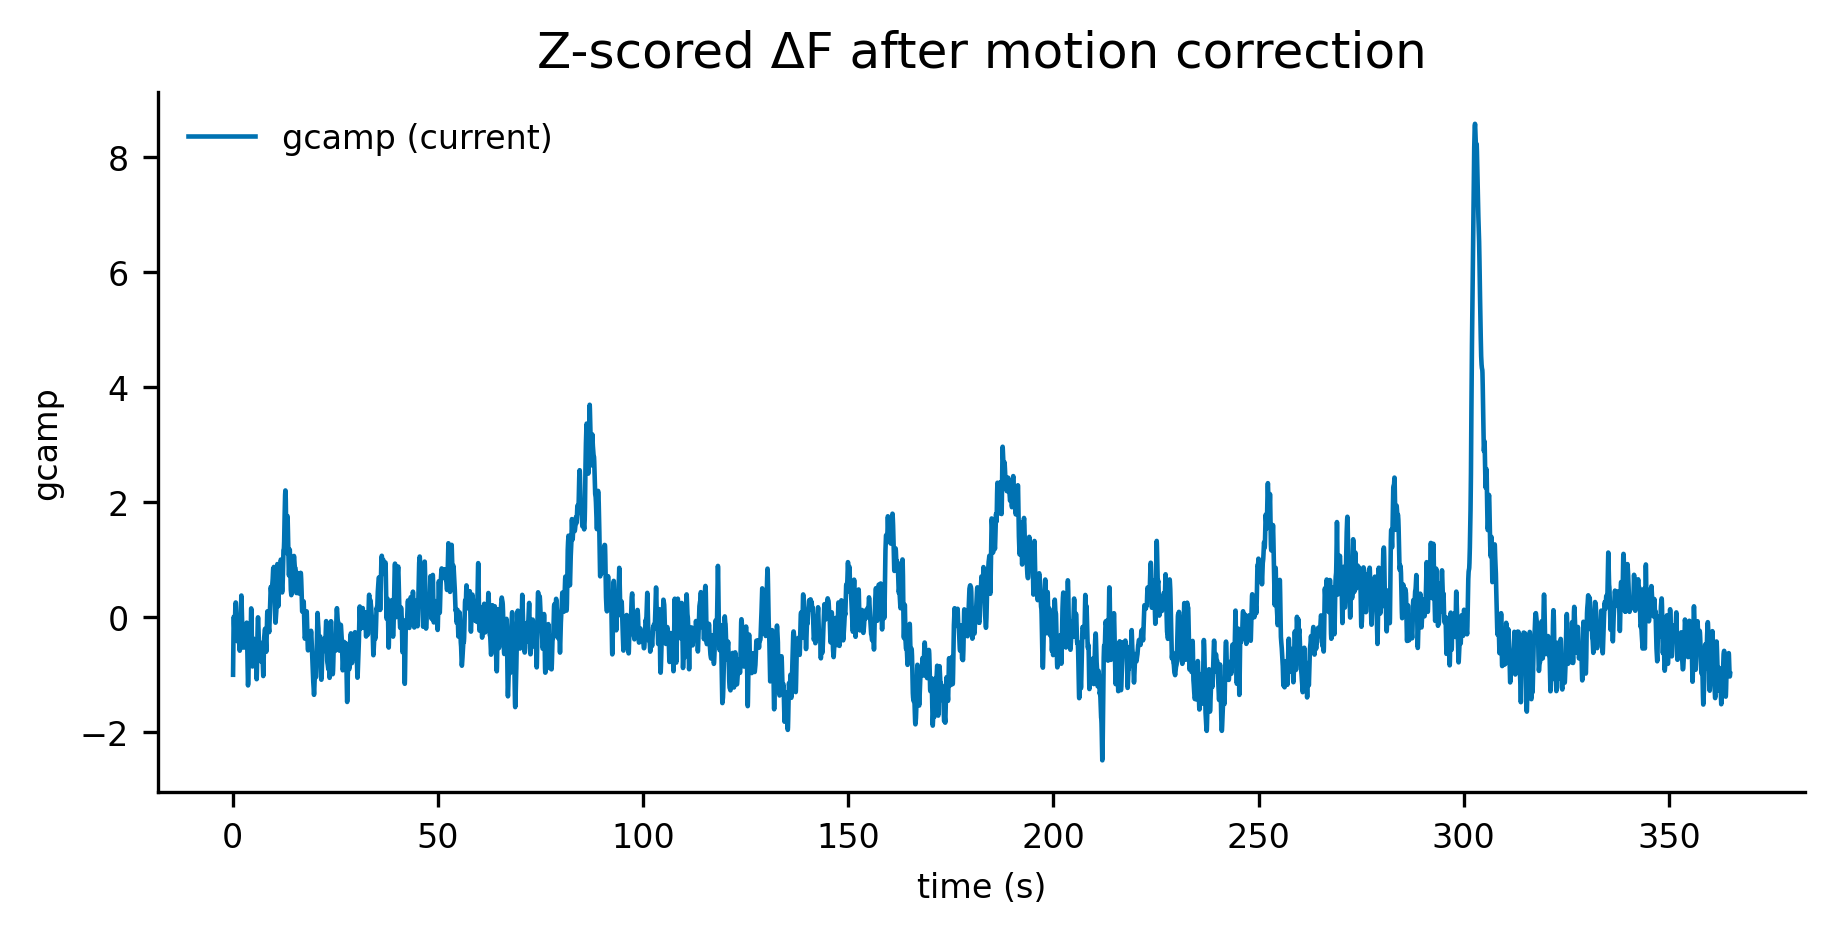

StageRecord(stage_id='0006_normalise', name='normalise', params={'method': 'z_score', 'channels': ['gcamp'], 'baseline_key': None, 'baseline_mode': 'percent', 'time_window': None, 'ddof': 0, 'null_z_scale': 'rms', 'mad_scale': 1.4826, 'eps': 1e-12}, metrics={}, notes=None)

In [12]:
# Z-score the motion-corrected ΔF trace.
# Option A: over the entire session
state_z = Normalise.z_score(
    channels=["gcamp"],
)(state)

fig, ax = state_z.plot(
    signal="gcamp",
    title="Z-scored ΔF after motion correction",
)
plt.show()

state_z.summary[-1]

## 8) reproducibility and audit trail

The full processing history is available via:
- `state.summary`: ordered list of stages and parameters
- `state.results`: per-stage fitted parameters/metrics
- `state.derived`: full time-series outputs (baselines, motion fits, etc.)


In [13]:
state_dff.summary

(StageRecord(stage_id='0001_trim', name='trim', params={'start': 0.0, 'end': 20.0, 'unit': 'seconds'}, metrics={}, notes='Trimmed time/signals (and any derived arrays matching signal shape).'),
 StageRecord(stage_id='0002_hampel_filter', name='hampel_filter', params={'window_size': 13, 'n_sigmas': 3.0, 'channels': 'all', 'mad_scale': 1.4826, 'mode': 'reflect', 'match_edges': True}, metrics={}, notes=None),
 StageRecord(stage_id='0003_low_pass_filter', name='low_pass_filter', params={'critical_frequency': 2.0, 'order': 2, 'sampling_rate': None, 'channels': 'all', 'representation': 'sos'}, metrics={}, notes=None),
 StageRecord(stage_id='0004_double_exp_baseline', name='double_exp_baseline', params={'subtract': True, 'channels': 'all', 'decimate_to_hz': None, 'maxfev': 2000, 'tau_fast_bounds': (60.0, 600.0), 'tau_slow_bounds': (600.0, 36000.0)}, metrics={'mean_r2': 0.9344294129266186, 'mean_rmse': 0.0007678413679641132, 'decimate_factor': 1.0}, notes="Fitted double exponential baseline; p

In [14]:
state_dff.results

{'0001_trim': {'unit': 'seconds',
  'start': 0.0,
  'end': 20.0,
  'start_samples': 0,
  'end_samples': 1205,
  'slice': (0, 21978),
  'old_n_samples': 23183,
  'new_n_samples': 21978},
 '0002_hampel_filter': {},
 '0003_low_pass_filter': {},
 '0004_double_exp_baseline': {'params': array([[5.08947661e-09, 9.01285661e-03, 2.87919342e-01, 9.68532215e+01,
          1.15836635e+04],
         [4.40165032e-12, 1.89841707e-03, 6.75743081e-02, 9.18092746e+01,
          1.50294413e+04]]),
  'r2': array([0.93109016, 0.93776867]),
  'rmse': array([0.00129698, 0.0002387 ]),
  'channels_fitted': [0, 1]},
 '0005_isosbestic_regression': {'control': 'iso',
  'control_idx': 1,
  'channels_fitted': [0],
  'method': 'irls_tukey',
  'include_intercept': True,
  'channels': {'gcamp': {'control': 'iso',
    'intercept': -0.00026857652785010913,
    'slope': 2.0109378164444216,
    'r2': -0.04112902715672728,
    'method': 'irls_tukey',
    'n_iter': 63,
    'max_iter': 100,
    'tuning_constant': 1.4,
    's

In [15]:
baseline = state_dff.derived["double_exp_baseline"][state_dff.idx("gcamp")]
baseline, baseline.shape


(array([0.29692083, 0.29691887, 0.29691692, ..., 0.27919965, 0.27919921,
        0.27919878], shape=(21978,)),
 (21978,))

## 9) full start → finish pipeline (single session)

Below is a minimal “one-liner” workflow using `state.pipe(...)` that runs the full
preprocessing pipeline in order:

1. Hampel filter (remove impulsive spikes/outliers)
2. Low-pass filter (reduce high-frequency noise)
3. Double exponential baseline fit (photobleaching model) + subtraction (detrend)
4. Isosbestic regression (motion correction) → returns ΔF
5. Normalisation (baseline-based %ΔF/F using the stored photobleaching baseline)

The output `state_final` contains:
- `state_final.signals`: the final processed signals
- `state_final.summary`: the ordered record of stages and parameters
- `state_final.results`: fit parameters / metrics for stages that estimate them
- `state_final.derived`: stored baselines (e.g. `"double_exp_baseline"`, `"motion_fit"`)
- `state_final.history`: snapshots you can plot/revert to


In [16]:
state0 = read_doric(path)

state_final = state0.pipe(
    Trim(end=20.0, unit="seconds"),
    HampelFilter(window_size=13, n_sigmas=3.0, channels="all"),
    LowPassFilter(critical_frequency=10.0, order=2, channels="all"),
    DoubleExpBaseline(subtract=True, channels="all"),
    IsosbesticRegression(
        control="iso",
        channels=["gcamp"],
        method="irls_tukey",
        tuning_constant=1.4,
        store_weights=False,
    ),
    Normalise.z_score(channels=["gcamp"]),
)

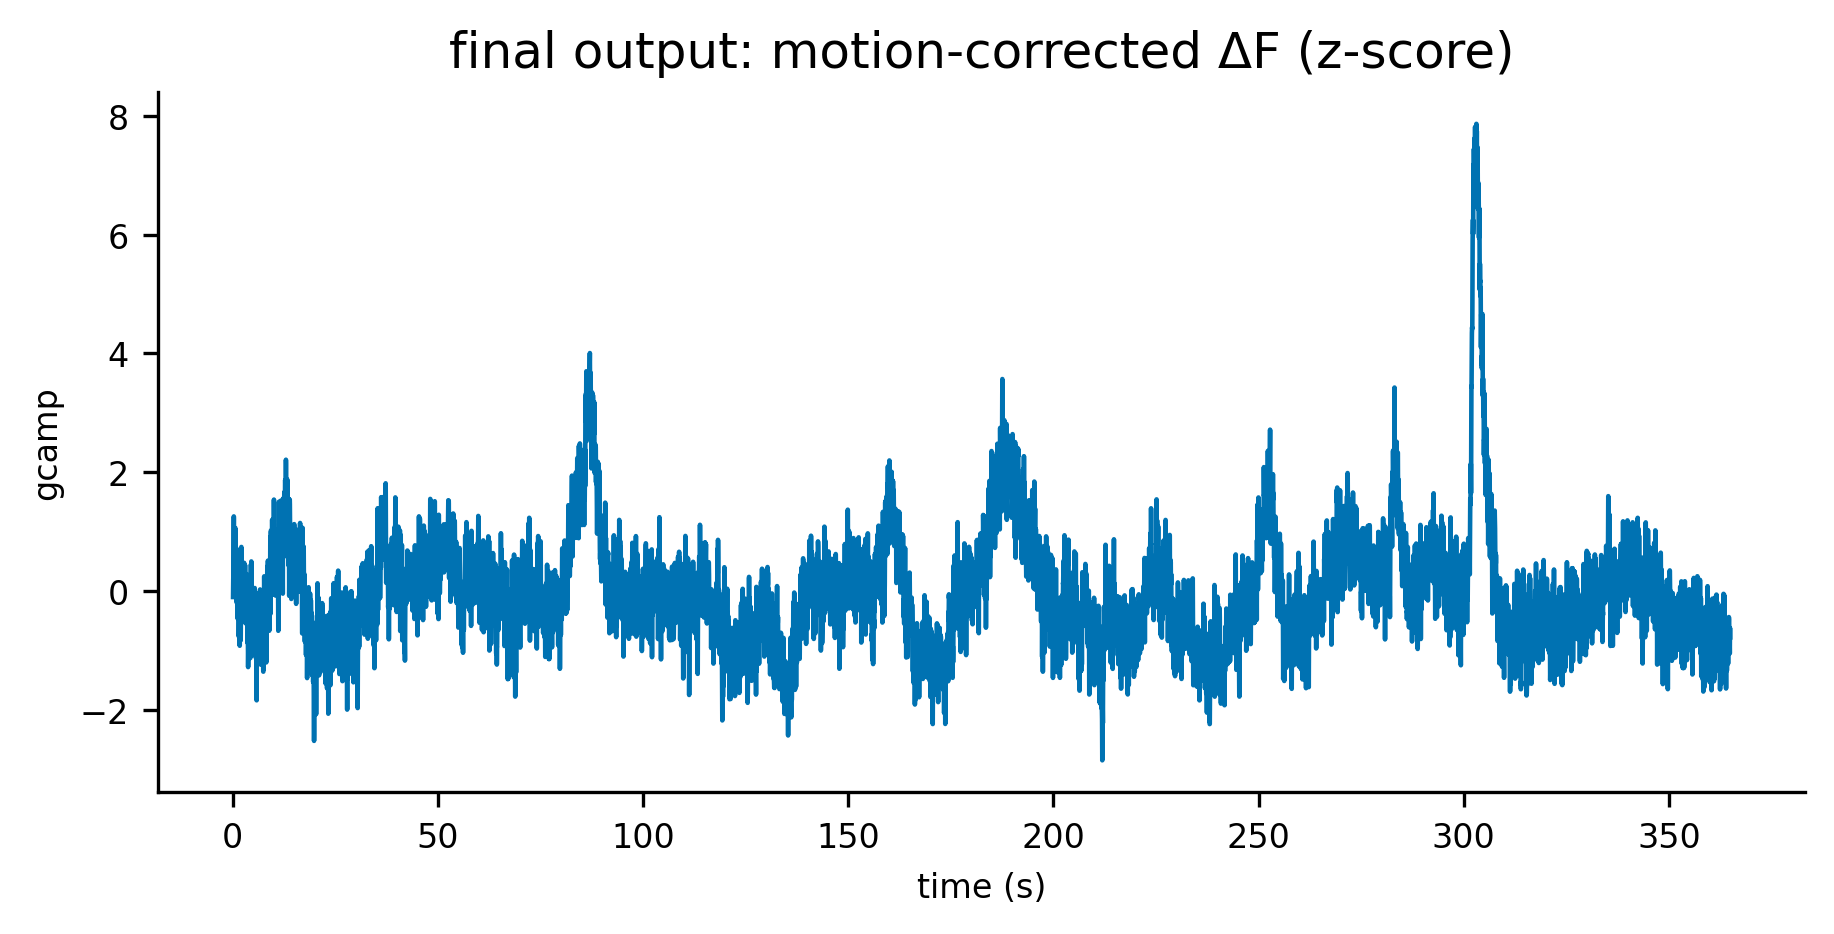

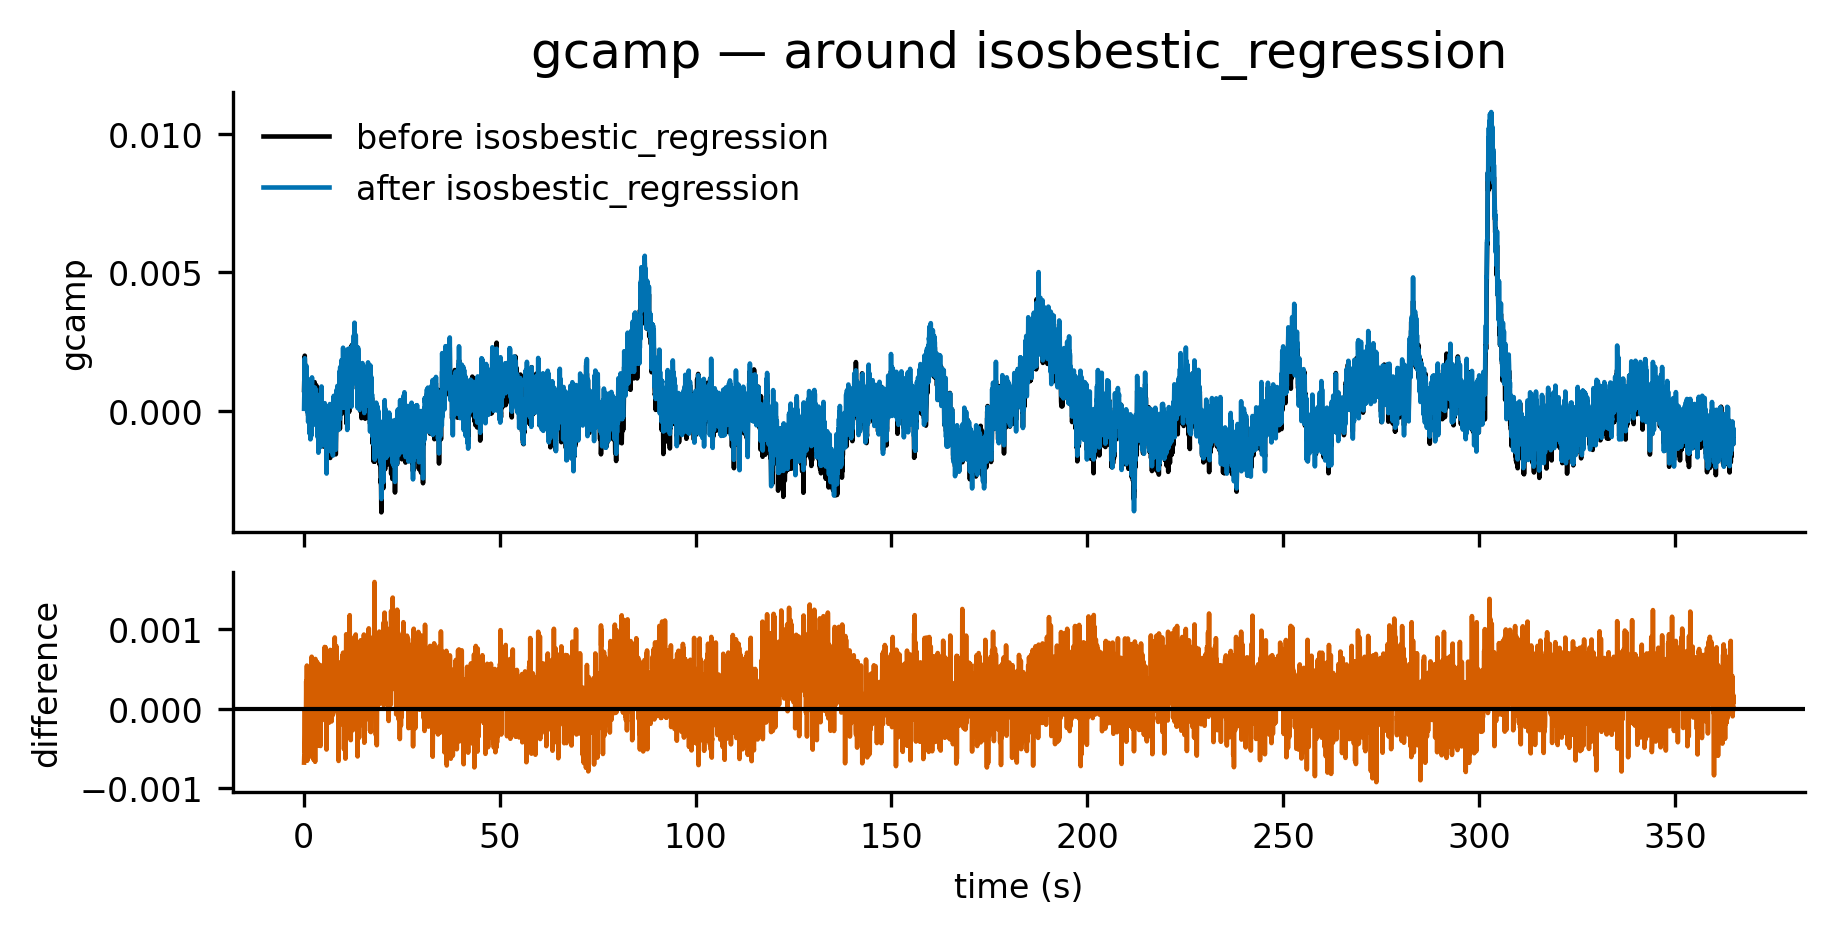

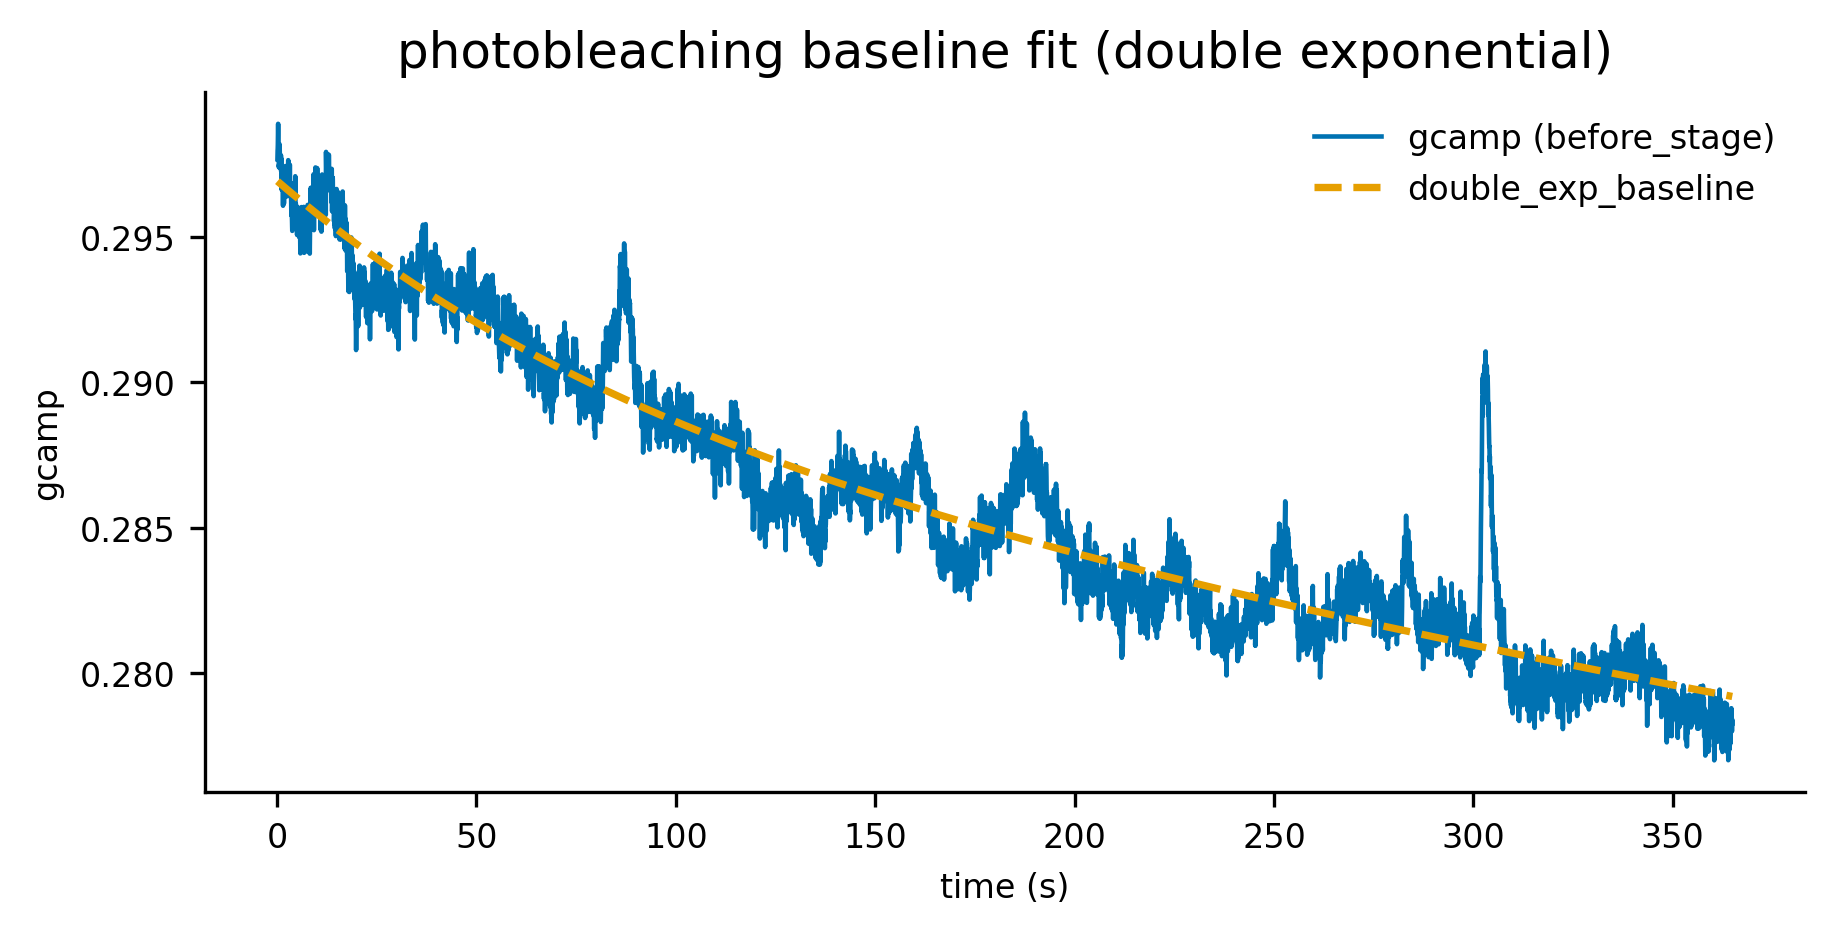

In [17]:
# a) final processed trace
fig, ax = state_final.plot(
    signal="gcamp",
    title="final output: motion-corrected ΔF (z-score)",
    show_legend=False,
)
plt.show()

# b) around-stage comparison (before/after) for a key step
fig, axes = state_final.plot_history(
    "gcamp",
    around=True,
    stage_name="isosbestic_regression",
    plot_difference=True,
)
plt.show()

# c) visualise the photobleaching fit
fig, ax = state_final.plot(
    signal="gcamp",
    view="before_stage",
    stage_name="double_exp_baseline",
    baseline_key="double_exp_baseline",
    title="photobleaching baseline fit (double exponential)",
)
plt.show()


---

## 10) Some post-analysis examples

In [18]:
def plot_auc_window(
    t: np.ndarray,
    y: np.ndarray,
    *,
    t0: float,
    t1: float,
    mode: str = "positive",  # "signed", "positive", "negative", "absolute"
    ax: Axes | None = None,
    label: str = "signal",
):
    t = np.asarray(t, float)
    y = np.asarray(y, float)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 3), dpi=150)
    else:
        fig = ax.figure

    m = np.isfinite(t) & np.isfinite(y) & (t >= t0) & (t <= t1)
    tt = t[m]
    yy = y[m]

    ax.plot(t, y, linewidth=1.2, label=label)
    ax.axhline(0.0, linewidth=1.0, alpha=0.6)

    if mode == "signed":
        contrib = yy
        y0 = 0.0
        ax.fill_between(tt, y0, contrib, alpha=0.25, label="signed area")
    elif mode == "positive":
        contrib = np.clip(yy, 0.0, np.inf)
        ax.fill_between(tt, 0.0, contrib, alpha=0.25, label="positive area")
    elif mode == "negative":
        contrib = np.clip(yy, -np.inf, 0.0)
        ax.fill_between(tt, 0.0, contrib, alpha=0.25, label="negative area")
    elif mode == "absolute":
        contrib = np.abs(yy)
        ax.fill_between(tt, 0.0, contrib, alpha=0.25, label="absolute area")
    else:
        raise ValueError(f"Unknown mode: {mode!r}")

    ax.set_xlabel("time (s)")
    ax.set_ylabel("Z-score" )
    ax.legend(frameon=False, fontsize=8)

    return fig, ax


def auc_window(t, y, *, t0, t1, mode="positive"):
    t = np.asarray(t, float)
    y = np.asarray(y, float)

    m = np.isfinite(t) & np.isfinite(y) & (t >= t0) & (t <= t1)
    tt = t[m]
    yy = y[m]

    if tt.size < 2:
        return np.nan  # not enough points to integrate

    if mode == "signed":
        contrib = yy
    elif mode == "positive":
        contrib = np.clip(yy, 0.0, np.inf)
    elif mode == "negative":
        contrib = np.clip(yy, -np.inf, 0.0)
    elif mode == "absolute":
        contrib = np.abs(yy)
    else:
        raise ValueError(f"Unknown mode: {mode!r}")

    area = np.trapezoid(contrib, tt)  # units: (ΔF/F %) * s
    return area

t = state_final.time_seconds
y = state_final.channel("gcamp")
area = auc_window(t, y, t0=0.0, t1=400.0, mode="positive")
print(f"Positive area under curve (0-400s): {area:.2f} (Z-score * s)")

Positive area under curve (0-400s): 126.82 (Z-score * s)


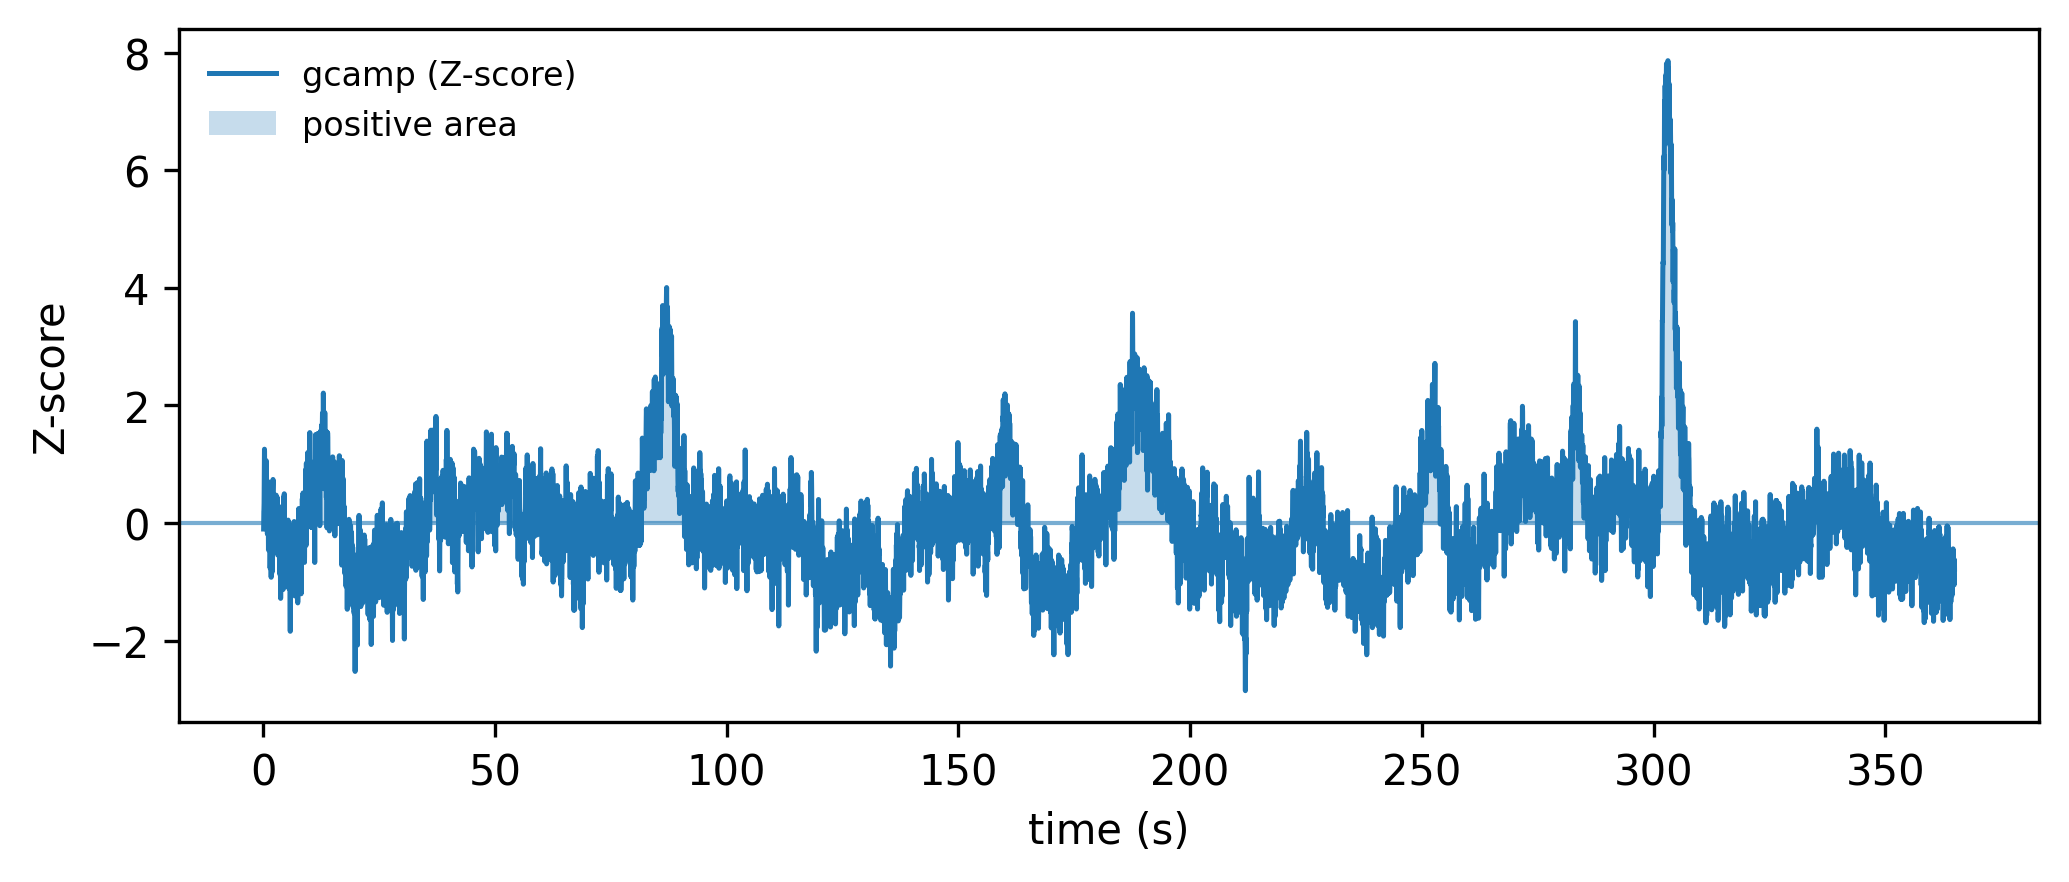

In [19]:
# plot.
fig, ax = plot_auc_window(
    t,
    y,
    t0=0.0,
    t1=400.0,
    mode="positive",
    label="gcamp (Z-score)",
)
plt.show()

In [20]:
finder = PeakFinder(
    kind="peak",
    height=float(np.std(y)),
    prominence=float(2.0 * np.std(y)),
    rel_height=0.5,
    baseline_mode="line",
    area_region="bases",
    width=int(round(1 * state.sampling_rate))
)

peaks = finder.fit(y, x=t)
peaks_fitted = peaks.fit_all(model="gaussian", window=2.0)
peaks_fitted.to_dataframe()

,kind,index,x,y,prominence,height,fwhm,left_ip,right_ip,left_base_index,right_base_index,area,fit_model,fit_r2,fit_rmse,fit_success
0,peak,776,12.978129,2.209867,4.051477,4.399804,1.529272,12.227826,13.757097,346,1189,32.801037,gaussian,0.296787,0.414489,True
1,peak,2240,37.280529,1.812858,3.592003,4.072074,1.912440,35.943982,37.856422,1189,4142,104.420148,gaussian,0.582702,0.349294,True
2,peak,5238,87.047329,4.005585,6.530077,6.644630,6.614389,82.867605,89.481994,1189,12760,515.859358,gaussian,0.089549,0.383700,True
3,peak,9635,160.037529,2.197593,4.438738,4.496321,3.844114,158.897757,162.741871,8148,10271,80.043539,gaussian,0.220026,0.315044,True
4,peak,11293,187.560329,3.568374,6.001734,6.287113,6.207157,184.589829,190.796986,8148,12760,206.791514,gaussian,0.350604,0.383088,True
5,peak,13557,225.142729,1.542295,3.783513,4.085540,1.330490,224.445572,225.776062,12760,14337,54.138792,gaussian,0.451190,0.353166,True
6,peak,15223,252.798329,2.716012,4.364505,4.502106,3.001044,250.907802,253.908845,12760,15541,88.876838,gaussian,0.272703,0.356964,True
7,peak,16361,271.689129,1.985598,2.801751,3.135902,1.029286,271.115038,272.144324,15541,16911,32.804274,gaussian,0.443497,0.317200,True
8,peak,17050,283.126529,3.425218,4.676487,4.972644,1.285528,282.552553,283.838081,12760,18024,177.253677,gaussian,0.253846,0.399185,True
9,peak,18252,303.079729,7.864888,9.625299,9.754282,2.916690,301.838337,304.755027,12760,18988,254.120588,gaussian,0.845560,0.318018,True


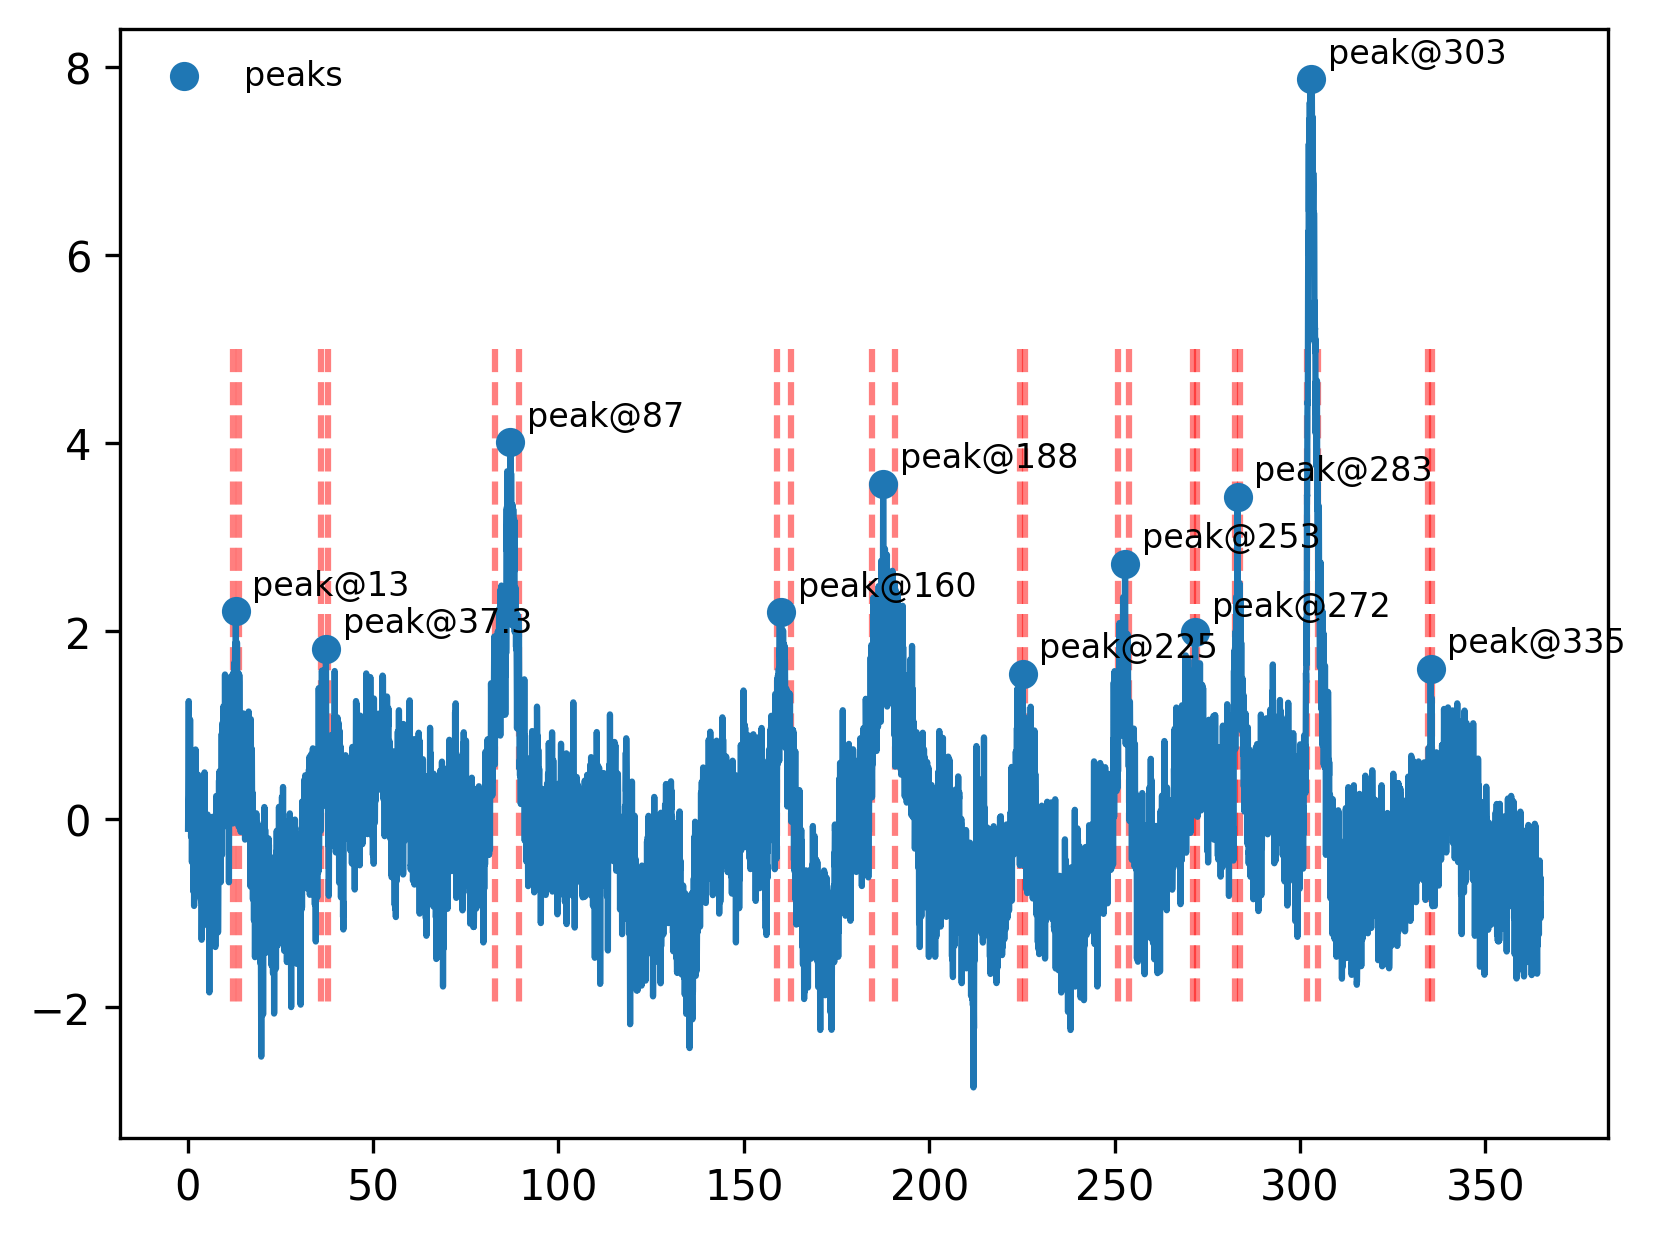

In [21]:
peak_sides = np.vstack([
    peaks_fitted.to_dataframe()["left_ip"],
    peaks_fitted.to_dataframe()["right_ip"]
])

fig, ax = peaks_fitted.plot(annotate=True)

for left, right in peak_sides.T:
    ax.vlines(
        [left, right],
        ymin=5,
        ymax=-2,
        colors="red",
        linestyles="dashed",
        alpha=0.5,
        zorder=-1,
    )

plt.show()

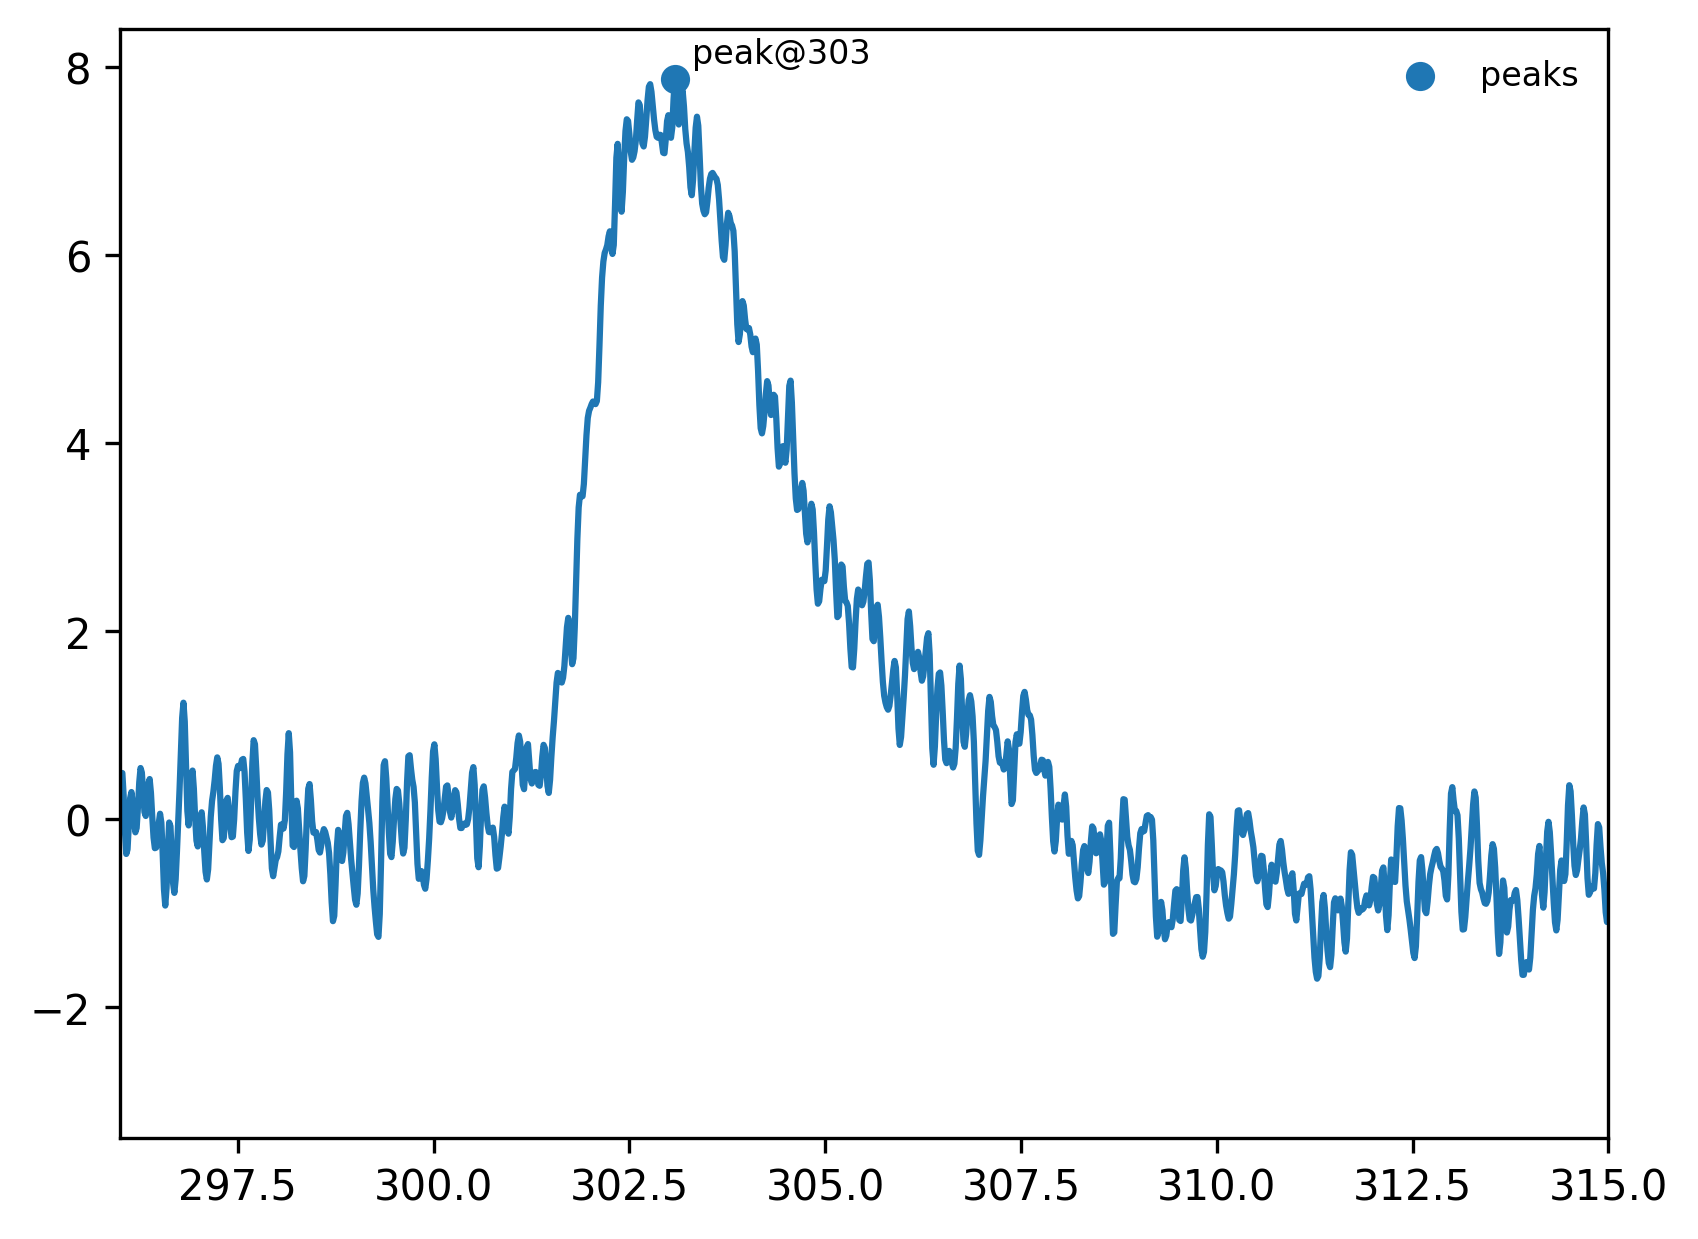

In [22]:
fig, ax = peaks_fitted.plot(annotate=True)
ax.set_xlim(300-4, 300+15)
plt.show()

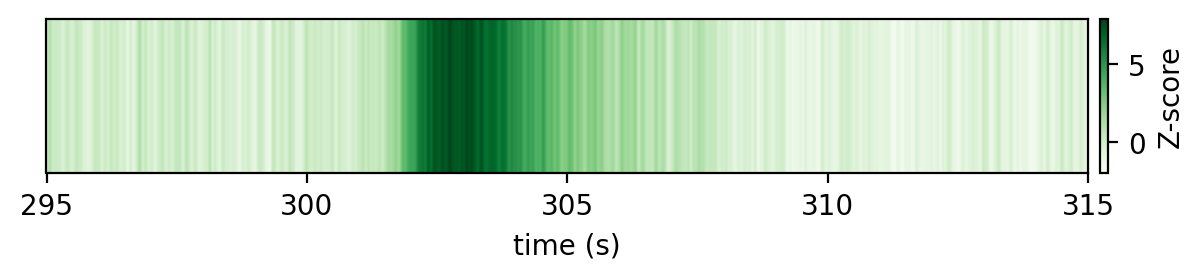

In [23]:
fig, ax = plt.subplots(figsize=(8,1))

data = np.expand_dims(y, axis=0)

cmap = ax.imshow(
    np.expand_dims(y, axis=0),
    aspect="auto",
    extent=(t[0], t[-1], 0, 1),
    cmap="Greens",
    vmin=-2, vmax=data.max(),
)

cbar = fig.colorbar(cmap, ax=ax, orientation="vertical", pad=0.01, aspect=20)
cbar.set_label("Z-score")

ax.set_xlim(300-5, 300+15)
ax.set_xticks(np.arange(295, 316, 5))

ax.set_yticks([])
ax.set_xlabel("time (s)")

plt.show()